In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from load_data import *
from helpers import *

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
#tf.compat.v1.disable_v2_behavior()
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
import shap

Init Plugin
Init Graph Optimizer
Init Kernel


# With decorrelated Variables

In [2]:
# define metric
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  r2 = r2.numpy()
  return r2

In [ ]:
np.random.seed(123)
param_grid = {
    'n_estimators': [100, 250, 500],
    'colsample_bytree': [0.1, 0.5, 0.9],
    'max_depth': [3,10,50],
    'gamma': [0, 1, 10],
    'reg_lambda': [0, 1, 10],
    'subsample': [0.5,0.7,0.9]
}


url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
# remove extreme prices
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
filter = price < 500
listings = listings[filter]
X_train, _ = train_test_split(listings, random_state = 123, test_size = 0.2)
X_train = X_train.reset_index(drop = True)

kf = KFold(n_splits=5)
cv_run = 0
fold_data = {}

# metrics
mse_val_para=[]
mae_val_para=[]
r_val_para = []
parameters = []
for n_estimators in tqdm(param_grid["n_estimators"]):
    for colsample_bytree in tqdm(param_grid["colsample_bytree"]):
        for max_depth in tqdm(param_grid["max_depth"]):
            for gamma in tqdm(param_grid["gamma"]):
                for reg_lambda in tqdm(param_grid["reg_lambda"]):
                    for subsample in tqdm(param_grid["subsample"]):
                        parameters.append([n_estimators, colsample_bytree, max_depth, gamma, reg_lambda, subsample])
                        mse_para = []
                        mae_para = []
                        r_para = []                            
                        c = 0                       
                        
                        for t, v in tqdm(kf.split(X_train), desc = "FOLD", total = 5):
                            # Model
                            params = {
                                'n_estimators': n_estimators,
                                'colsample_bytree': colsample_bytree,
                                'max_depth': max_depth,
                                'gamma': gamma,
                                'reg_lambda': reg_lambda,
                                'subsample': subsample
                                }
                            model_fold = xgb.XGBRegressor(**params)
                            
                            # Data
                            if cv_run > 0:
                                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]
                            else:
                                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(train_idx = t, val_idx = v)
                            
                            # Fit
                            model_fold.fit(X_train_kf, y_train_kf)
                            
                            # Metrics
                            #y_tr_pred = model.predict(X_train_kf)
                            y_val_pred = model_fold.predict(X_val_kf)
                            y_test_pred = model_fold.predict(X_test)
                            
                            #mse_tr = mean_squared_error(X_train_kf, y_tr_pred)
                            mse_val = mean_squared_error(y_val_kf, y_val_pred)
                            #mse_test = mean_squared_error(y_test, y_test_pred)
                        
                            #mae_tr = mean_absolute_error(X_train_kf, y_tr_pred)
                            mae_val = mean_absolute_error(y_val_kf, y_val_pred)
                            #mae_test = mean_absolute_error(y_test, y_test_pred)  
                            
                            #r_tr = model_fold.score(X_train_kf, y_tr_pred)
                            r_val = R_squared(y_val_kf, y_val_pred)
                            r_test = R_squared(y_test, y_test_pred)  
                                                        
                            # print("FOLD ",c)
                            # print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
                            # print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
                            # print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
                            
                            # save mse, mae, r2 of fold
                            mse_para.append(mse_val)
                            mae_para.append(mae_val)
                            r_para.append(r_val)
                            
                            # save fold data
                            if cv_run == 0:
                                fold_data[str(c)] = [X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf]
                            c += 1

                        cv_run += 1
                        mse_val_para.append(np.nanmean(np.array(mse_para)))
                        mae_val_para.append(np.nanmean(np.array(mae_para)))
                        r_val_para.append(np.nanmean(np.array(r_para)))




In [11]:
parameters = np.stack(parameters)
results_cor = pd.DataFrame({'n_estimators':parameters[:,0],
                            "colsample_bytree":parameters[:,1],
                            "max_depth":parameters[:,2],
                            "gamma":parameters[:,3],
                            "reg_lambda":parameters[:,4],
                            "subsample":parameters[:,5],
                            "MSE": mse_val_para,
                            "MAE": mae_val_para,
                            "R2": r_val_para}
    )
results_cor.to_csv("results_gs_xgboost_pca.csv")

In [13]:
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
# remove extreme prices
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
filter = price < 500
listings = listings[filter]
X_train, _ = train_test_split(listings, random_state = 123, test_size = 0.2)
X_train = X_train.reset_index(drop = True)

kf = KFold(n_splits=5)

c = 0                       

for t, v in tqdm(kf.split(X_train), desc = "FOLD", total = 5):
    # Model
    params = {
        'n_estimators': 500,
        'colsample_bytree': 0.5,
        'max_depth': 10,
        'gamma': 1,
        'reg_lambda': 1,
        'subsample': 0.9
        }
    model_fold = xgb.XGBRegressor(**params)
    
    # Data
    X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(train_idx = t, val_idx = v, for_dendro=False)
    
    # Fit
    model_fold.fit(X_train_kf, y_train_kf)
    
    # Metrics
    y_tr_pred = model_fold.predict(X_train_kf)
    y_val_pred = model_fold.predict(X_val_kf)
    y_test_pred = model_fold.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_kf, y_tr_pred)
    mse_val = mean_squared_error(y_val_kf, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    mae_tr = mean_absolute_error(y_train_kf, y_tr_pred)
    mae_val = mean_absolute_error(y_val_kf, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    r_tr = R_squared(y_train_kf, y_tr_pred)
    r_val = R_squared(y_val_kf, y_val_pred)
    r_test = R_squared(y_test, y_test_pred)  
                                
    print("FOLD ",c)
    print("Train: ", r_tr, mse_tr, mae_tr)
    print("Validation: ", r_val, mse_val, mae_val)
    print("Test: ", r_test, mse_test, mae_test)
      
    c += 1
  

FOLD:   0%|          | 0/5 [00:00<?, ?it/s]

------------------------------
Fit listings...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
61 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra_pillows_and_blankets', 'Luggage_dropoff_allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'host_location_country_Ireland', 'neighbourhood_cleansed_Dn_Laoghaire-Rathdown']
------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
61 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra_pillows_and_blankets', 'Luggage_

In [3]:
params = {
        'n_estimators': 500,
        'colsample_bytree': 0.5,
        'max_depth': 10,
        'gamma': 1,
        'reg_lambda': 1,
        'subsample': 0.9
        }

model_fold = xgb.XGBRegressor(**params)
# Data
X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_fold(fold = 5)

# also unnormalized data
_, X_test_shap, _, _, _, _ = load_data_fold(fold=5, for_dendro=True, standardize=False)

model_fold.fit(X_train_kf, y_train_kf)
# Metrics
y_tr_pred = model_fold.predict(X_train_kf)
y_val_pred = model_fold.predict(X_val_kf)
y_test_pred = model_fold.predict(X_test)

mse_tr = mean_squared_error(y_train_kf, y_tr_pred)
mse_val = mean_squared_error(y_val_kf, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

mae_tr = mean_absolute_error(y_train_kf, y_tr_pred)
mae_val = mean_absolute_error(y_val_kf, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)  

r_tr = R_squared(y_train_kf, y_tr_pred)
r_val = R_squared(y_val_kf, y_val_pred)
r_test = R_squared(y_test, y_test_pred)  
                            
print("Train: ", r_tr, mse_tr, mae_tr)
print("Validation: ", r_val, mse_val, mae_val)
print("Test: ", r_test, mse_test, mae_test)
      


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Train:  0.8830434789796652 0.05134681634420156 0.17556502995533743
Validation:  0.6455988673622395 0.15092563774148934 0.2861539607885001
Test:  0.6178349427857457 0.15174154456186392 0.29136462495942045


2022-02-19 13:13:01.141523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-19 13:13:01.141860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model_fold.score(X_val_kf, y_val_kf)

0.6455988673622395

In [8]:
def get_aggr_shap(values):
    
    feat = values.feature_names 
    filter = pd.Series(feat).str.contains(r"_pca").values
    feat_pca = np.array(feat)[filter].tolist()
    
    splits = np.unique(pd.Series(feat_pca).str.split((r"_pca\d|_pca$"), expand = True).values[:,0])
    new_feat = values.feature_names
    new_values = values.values
    new_data = values.data
    for i in splits:
        regex_filter = pd.Series(new_feat).str.contains(i).values
        # drop feature names
        new_feat = np.array(new_feat)[~regex_filter].tolist()
        new_feat.append(i)
        
        # aggregated values
        values_filtered = new_values[:,np.where(regex_filter)[0].tolist()]   
        values_aggr = values_filtered.sum(axis = 1)
        # drop values
        new_values = new_values[:,  np.where(~regex_filter)[0].tolist()]
        #new_values = np.concatenate((new_values, values_aggr), axis = 0)
        new_values = np.c_[new_values, values_aggr]
        
        # alter data matrix
        new_data = new_data[:,  np.where(~regex_filter)[0].tolist()]
        new_data = np.c_[new_data, np.repeat(np.NaN,new_data.shape[0])]

    values.feature_names=new_feat
    values.values = new_values
    values.data = new_data
    #values.data[:,-len(splits):] = np.full((values.data.shape[0], len(splits)), np.NaN)
    
    # replace data of non pca variables with actual values
    col_raw = X_test_shap.columns.tolist()
    col_shap = values.feature_names
    col_new = []
    for i in col_raw:
        if i in col_shap:
            col_new.append(i)
    
    for i in col_new:
        index_shap = np.where(np.array(col_shap) == i)
        values.data[:,index_shap] = X_test_shap[i].values.reshape((X_test_shap[i].values.shape[0],1,1))
    
    return values

In [9]:
X_test_shap.loc[:,["room_type_Private_room", "room_type_Entire_home/apt", 
                    "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
                    "bedrooms_1", "bedrooms_2", "accommodates", "beds", 
                    "property_type_Private_room_in_residential_home", "property_type_Entire_rental_unit",
                    "property_type_Private_room_in_rental_unit", "property_type_Entire_residential_home"]].mean()

room_type_Private_room                            0.523846
room_type_Entire_home/apt                         0.451173
bath_number_1                                     0.684330
bath_number_2                                     0.269493
bath_kind_Shared                                  0.266465
bath_kind_Private                                 0.167298
bath_kind_Normal                                  0.566238
bedrooms_1                                        0.719152
bedrooms_2                                        0.184709
accommodates                                      2.774413
beds                                              1.678274
property_type_Private_room_in_residential_home    0.000000
property_type_Entire_rental_unit                  0.223316
property_type_Private_room_in_rental_unit         0.000000
property_type_Entire_residential_home             0.118849
dtype: float64

In [10]:
print(X_test_shap.loc[[8,588],["room_type_Private_room", "room_type_Entire_home/apt", 
                    "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
                    "bedrooms_1", "bedrooms_2", "accommodates", "beds", 
                    "property_type_Private_room_in_residential_home", "property_type_Entire_rental_unit",
                    "property_type_Private_room_in_rental_unit", "property_type_Entire_residential_home"]].T.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  8   &  588 \\
\midrule
room\_type\_Private\_room                         &  1.0 &  0.0 \\
room\_type\_Entire\_home/apt                      &  0.0 &  1.0 \\
bath\_number\_1                                  &  1.0 &  1.0 \\
bath\_number\_2                                  &  0.0 &  0.0 \\
bath\_kind\_Shared                               &  0.0 &  0.0 \\
bath\_kind\_Private                              &  1.0 &  0.0 \\
bath\_kind\_Normal                               &  0.0 &  1.0 \\
bedrooms\_1                                     &  1.0 &  0.0 \\
bedrooms\_2                                     &  0.0 &  1.0 \\
accommodates                                   &  1.0 &  6.0 \\
beds                                           &  1.0 &  2.0 \\
property\_type\_Private\_room\_in\_residential\_home &  0.0 &  0.0 \\
property\_type\_Entire\_rental\_unit               &  0.0 &  0.0 \\
property\_type\_Private\_room\_in\_rental\_unit      &  0.0 &  0.0 \\
property\_t

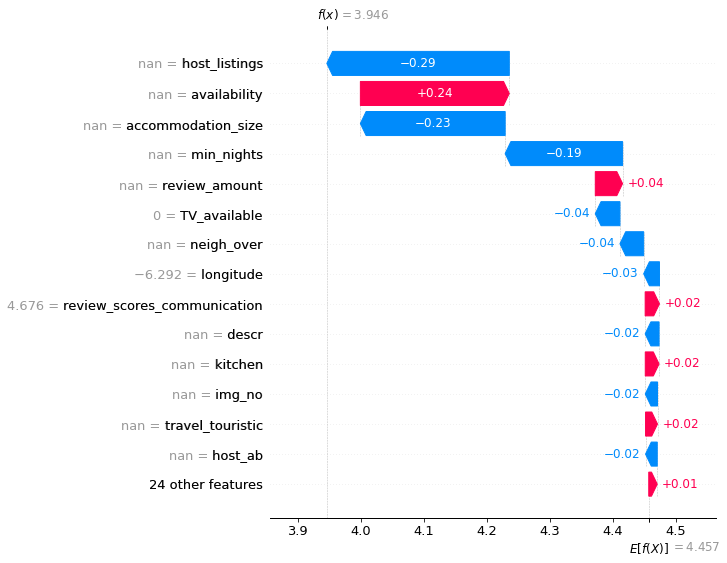

In [72]:
explainer = shap.Explainer(model_fold)
shap_values = explainer(X_test)
shap_values = get_aggr_shap(shap_values)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[8], max_display = 15)

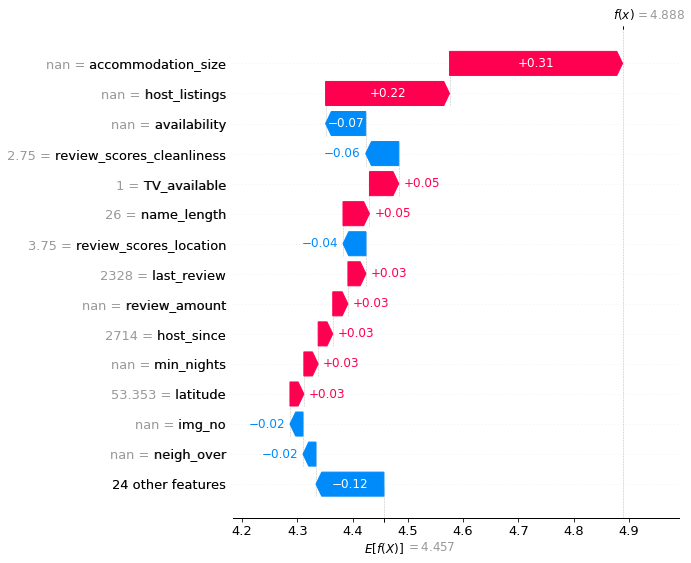

In [73]:

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[588], max_display = 15)

All-NaN slice encountered


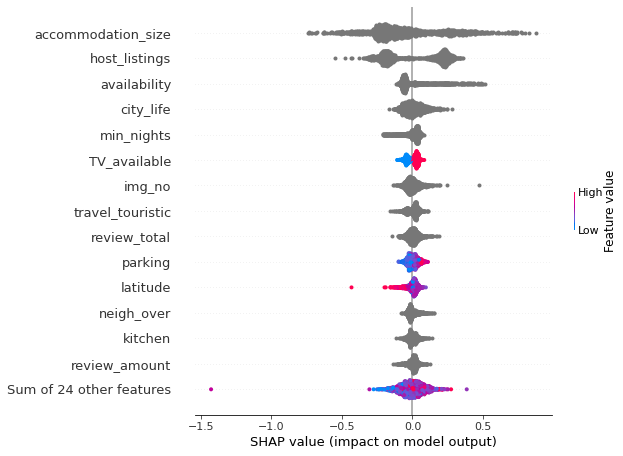

In [71]:
shap.plots.beeswarm(shap_values, max_display=15)


## Adjusted $R^2$

In [11]:
1 - (1-model_fold.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.5967562945461101

## Save best model

In [48]:
model_fold.save_model("xgBoost_models/model_pca.json")

In [40]:
# load
opt_params = {
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'max_depth': 10,
    'gamma': 1,
    'reg_lambda': 1,
    'subsample': 0.9
    }

model_new = xgb.XGBRegressor(**opt_params)
model_new.load_model("xgBoost_models/model_pca.json")

## Munich Data

In [41]:
X_munich, y_munich, X_munich_shap = load_data_munich_fold(fold = 5, verbose = 0)

In [44]:
model_new.score(X_munich, y_munich)

0.26318734312184466

In [47]:
y_munich_pred = model_new.predict(X_munich)

r_mu = R_squared(y_munich, y_munich_pred)
mse_mu = mean_squared_error(y_munich, y_munich_pred)
mae_mu = mean_absolute_error(y_munich, y_munich_pred)

print(r_mu, mse_mu, mae_mu)

0.2631873431218452 0.3234848513994957 0.4573621233204098


In [45]:
def get_aggr_shap_munich(values):
    
    feat = values.feature_names 
    filter = pd.Series(feat).str.contains(r"_pca").values
    feat_pca = np.array(feat)[filter].tolist()
    
    splits = np.unique(pd.Series(feat_pca).str.split((r"_pca\d|_pca$"), expand = True).values[:,0])
    new_feat = values.feature_names
    new_values = values.values
    new_data = values.data
    for i in splits:
        regex_filter = pd.Series(new_feat).str.contains(i).values
        # drop feature names
        new_feat = np.array(new_feat)[~regex_filter].tolist()
        new_feat.append(i)
        
        # aggregated values
        values_filtered = new_values[:,np.where(regex_filter)[0].tolist()]   
        values_aggr = values_filtered.sum(axis = 1)
        # drop values
        new_values = new_values[:,  np.where(~regex_filter)[0].tolist()]
        #new_values = np.concatenate((new_values, values_aggr), axis = 0)
        new_values = np.c_[new_values, values_aggr]
        
        # alter data matrix
        new_data = new_data[:,  np.where(~regex_filter)[0].tolist()]
        new_data = np.c_[new_data, np.repeat(np.NaN,new_data.shape[0])]

    values.feature_names=new_feat
    values.values = new_values
    values.data = new_data
    #values.data[:,-len(splits):] = np.full((values.data.shape[0], len(splits)), np.NaN)
    
    # replace data of non pca variables with actual values
    col_raw = X_munich_shap.columns.tolist()
    col_shap = values.feature_names
    col_new = []
    for i in col_raw:
        if i in col_shap:
            col_new.append(i)
    
    for i in col_new:
        index_shap = np.where(np.array(col_shap) == i)
        values.data[:,index_shap] = X_munich_shap[i].values.reshape((X_munich_shap[i].values.shape[0],1,1))
    
    return values

All-NaN slice encountered


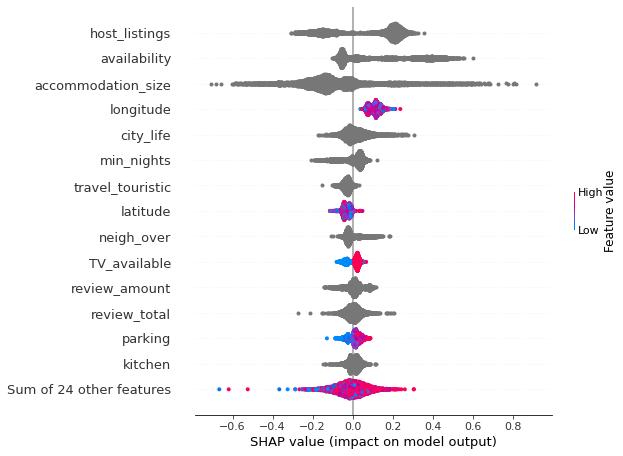

In [46]:
explainer = shap.Explainer(model_new)
shap_values = explainer(X_munich)
shap_values = get_aggr_shap_munich(shap_values)
shap.plots.beeswarm(shap_values, max_display=15)

# Without decorrelation

In [ ]:
np.random.seed(123)
param_grid = {
    'n_estimators': [100, 250, 500],
    'colsample_bytree': [0.1, 0.5, 0.9],
    'max_depth': [3,10,50],
    'gamma': [0, 1, 10],
    'reg_lambda': [0, 1, 10],
    'subsample': [0.5,0.7,0.9]
}

url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
# remove extreme prices
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
filter = price < 500
listings = listings[filter]
X_train, _ = train_test_split(listings, random_state = 123, test_size = 0.2)
X_train = X_train.reset_index(drop = True)

kf = KFold(n_splits=5)
cv_run = 0
fold_data = {}

# metrics
mse_val_para=[]
mae_val_para=[]
r_val_para = []
parameters = []
for n_estimators in tqdm(param_grid["n_estimators"]):
    for colsample_bytree in tqdm(param_grid["colsample_bytree"]):
        for max_depth in tqdm(param_grid["max_depth"]):
            for gamma in tqdm(param_grid["gamma"]):
                for reg_lambda in tqdm(param_grid["reg_lambda"]):
                    for subsample in tqdm(param_grid["subsample"]):
                        parameters.append([n_estimators, colsample_bytree, max_depth, gamma, reg_lambda, subsample])
                        mse_para = []
                        mae_para = []
                        r_para = []                            
                        c = 0                       
                        
                        for t, v in tqdm(kf.split(X_train), desc = "FOLD", total = 5):
                            # Model
                            params = {
                                'n_estimators': n_estimators,
                                'colsample_bytree': colsample_bytree,
                                'max_depth': max_depth,
                                'gamma': gamma,
                                'reg_lambda': reg_lambda,
                                'subsample': subsample
                                }
                            model_fold = xgb.XGBRegressor(**params)
                            
                            # Data
                            if cv_run > 0:
                                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]
                            else:
                                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(train_idx = t, val_idx = v, for_dendro=True)
                            
                            # Fit
                            model_fold.fit(X_train_kf, y_train_kf)
                            
                            # Metrics
                            #y_tr_pred = model.predict(X_train_kf)
                            y_val_pred = model_fold.predict(X_val_kf)
                            y_test_pred = model_fold.predict(X_test)
                            
                            #mse_tr = mean_squared_error(X_train_kf, y_tr_pred)
                            mse_val = mean_squared_error(y_val_kf, y_val_pred)
                            #mse_test = mean_squared_error(y_test, y_test_pred)
                        
                            #mae_tr = mean_absolute_error(X_train_kf, y_tr_pred)
                            mae_val = mean_absolute_error(y_val_kf, y_val_pred)
                            #mae_test = mean_absolute_error(y_test, y_test_pred)  
                            
                            #r_tr = model_fold.score(X_train_kf, y_tr_pred)
                            r_val = R_squared(y_val_kf, y_val_pred)
                            r_test = R_squared(y_test, y_test_pred)  
                                                        
                            # print("FOLD ",c)
                            # print("Train: ", model_fold.score(X_train_tmp, y_train_tmp), mse_tr, mae_tr)
                            # print("Validation: ",model_fold.score(X_val_tmp, y_val_tmp), mse_val, mae_val)
                            # print("Test: ",model_fold.score(X_test, y_test), mse_test, mae_test)
                            
                            # save mse, mae, r2 of fold
                            mse_para.append(mse_val)
                            mae_para.append(mae_val)
                            r_para.append(r_val)
                            
                            # save fold data
                            if cv_run == 0:
                                fold_data[str(c)] = [X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf]
                            c += 1

                        cv_run += 1
                        mse_val_para.append(np.nanmean(np.array(mse_para)))
                        mae_val_para.append(np.nanmean(np.array(mae_para)))
                        r_val_para.append(np.nanmean(np.array(r_para)))




In [5]:
parameters = np.stack(parameters)
results = pd.DataFrame({'n_estimators':parameters[:,0],
                            "colsample_bytree":parameters[:,1],
                            "max_depth":parameters[:,2],
                            "gamma":parameters[:,3],
                            "reg_lambda":parameters[:,4],
                            "subsample":parameters[:,5],
                            "MSE": mse_val_para,
                            "MAE": mae_val_para,
                            "R2": r_val_para}
    )
results.to_csv("results_gs_xgboost.csv")

In [10]:
results.iloc[np.argmax(results["R2"])]

n_estimators        100.000000
colsample_bytree      0.500000
max_depth             3.000000
gamma                 1.000000
reg_lambda           10.000000
subsample             0.900000
MSE                   0.139678
MAE                   0.275993
R2                    0.679768
Name: 98, dtype: float64

In [26]:
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
# remove extreme prices
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
filter = price < 500
listings = listings[filter]
X_train, _ = train_test_split(listings, random_state = 123, test_size = 0.2)
X_train = X_train.reset_index(drop = True)

kf = KFold(n_splits=5)

c = 0                       

for t, v in tqdm(kf.split(X_train), desc = "FOLD", total = 5):
    # Model
    params = {
        'n_estimators': 100,
        'colsample_bytree': 0.5,
        'max_depth': 3,
        'gamma': 1,
        'reg_lambda': 10,
        'subsample': 0.9
        }
    model_fold = xgb.XGBRegressor(**params)
    
    # Data
    X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(train_idx = t, val_idx = v, for_dendro=True)
    
    # Fit
    model_fold.fit(X_train_kf, y_train_kf)
    
    # Metrics
    y_tr_pred = model_fold.predict(X_train_kf)
    y_val_pred = model_fold.predict(X_val_kf)
    y_test_pred = model_fold.predict(X_test)
    
    mse_tr = mean_squared_error(y_train_kf, y_tr_pred)
    mse_val = mean_squared_error(y_val_kf, y_val_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    mae_tr = mean_absolute_error(y_train_kf, y_tr_pred)
    mae_val = mean_absolute_error(y_val_kf, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)  
    
    r_tr = R_squared(y_train_kf, y_tr_pred)
    r_val = R_squared(y_val_kf, y_val_pred)
    r_test = R_squared(y_test, y_test_pred)  
                                
    print("FOLD ",c)
    print("Train: ", r_tr, mse_tr, mae_tr)
    print("Validation: ", r_val, mse_val, mae_val)
    print("Test: ", r_test, mse_test, mae_test)
      
    c += 1


FOLD:   0%|          | 0/5 [00:00<?, ?it/s]

------------------------------
Fit listings...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
61 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra_pillows_and_blankets', 'Luggage_dropoff_allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'host_location_country_Ireland', 'neighbourhood_cleansed_Dn_Laoghaire-Rathdown']
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
61 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra_pillows_and_blankets', 'Luggage_dropoff_allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'host_location_country_Ireland', 'neighbourhood_c

In [19]:
params = {
        'n_estimators': 100,
        'colsample_bytree': 0.5,
        'max_depth': 3,
        'gamma': 1,
        'reg_lambda': 10,
        'subsample': 0.9
        }

model_fold = xgb.XGBRegressor(**params)
# Data
X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_fold(fold = 1, for_dendro = True)

# also unnormalized data
_, X_test_shap, _, _, _, _ = load_data_fold(fold=1, for_dendro=True, standardize=False)

model_fold.fit(X_train_kf, y_train_kf)
# Metrics
y_tr_pred = model_fold.predict(X_train_kf)
y_val_pred = model_fold.predict(X_val_kf)
y_test_pred = model_fold.predict(X_test)

mse_tr = mean_squared_error(y_train_kf, y_tr_pred)
mse_val = mean_squared_error(y_val_kf, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

mae_tr = mean_absolute_error(y_train_kf, y_tr_pred)
mae_val = mean_absolute_error(y_val_kf, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)  

r_tr = R_squared(y_train_kf, y_tr_pred)
r_val = R_squared(y_val_kf, y_val_pred)
r_test = R_squared(y_test, y_test_pred)  
                            
print("Train: ", r_tr, mse_tr, mae_tr)
print("Validation: ", r_val, mse_val, mae_val)
print("Test: ", r_test, mse_test, mae_test)
      

Train:  0.765667820028576 0.10221176484819264 0.23763197810619582
Validation:  0.6884972115891639 0.13614885631585497 0.2739930257190794
Test:  0.6485437832061149 0.13954836575305873 0.2776333205523216


In [20]:
model_fold.score(X_val_kf, y_val_kf)

0.6884972115891639

In [21]:
explainer = shap.Explainer(model_fold)
shap_values = explainer(X_test)
shap_values.data = X_test_shap

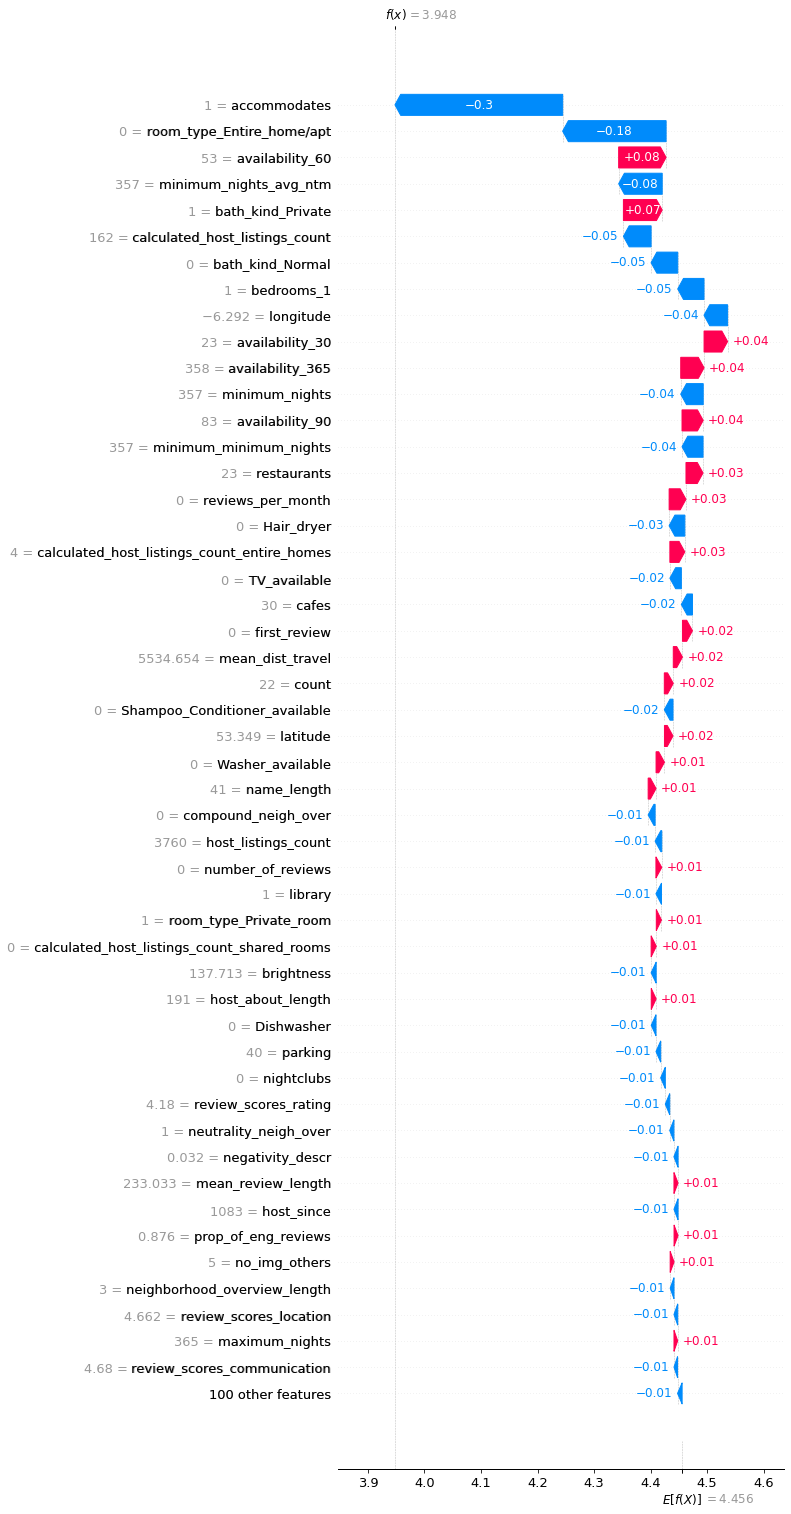

In [22]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[8], max_display = 50)

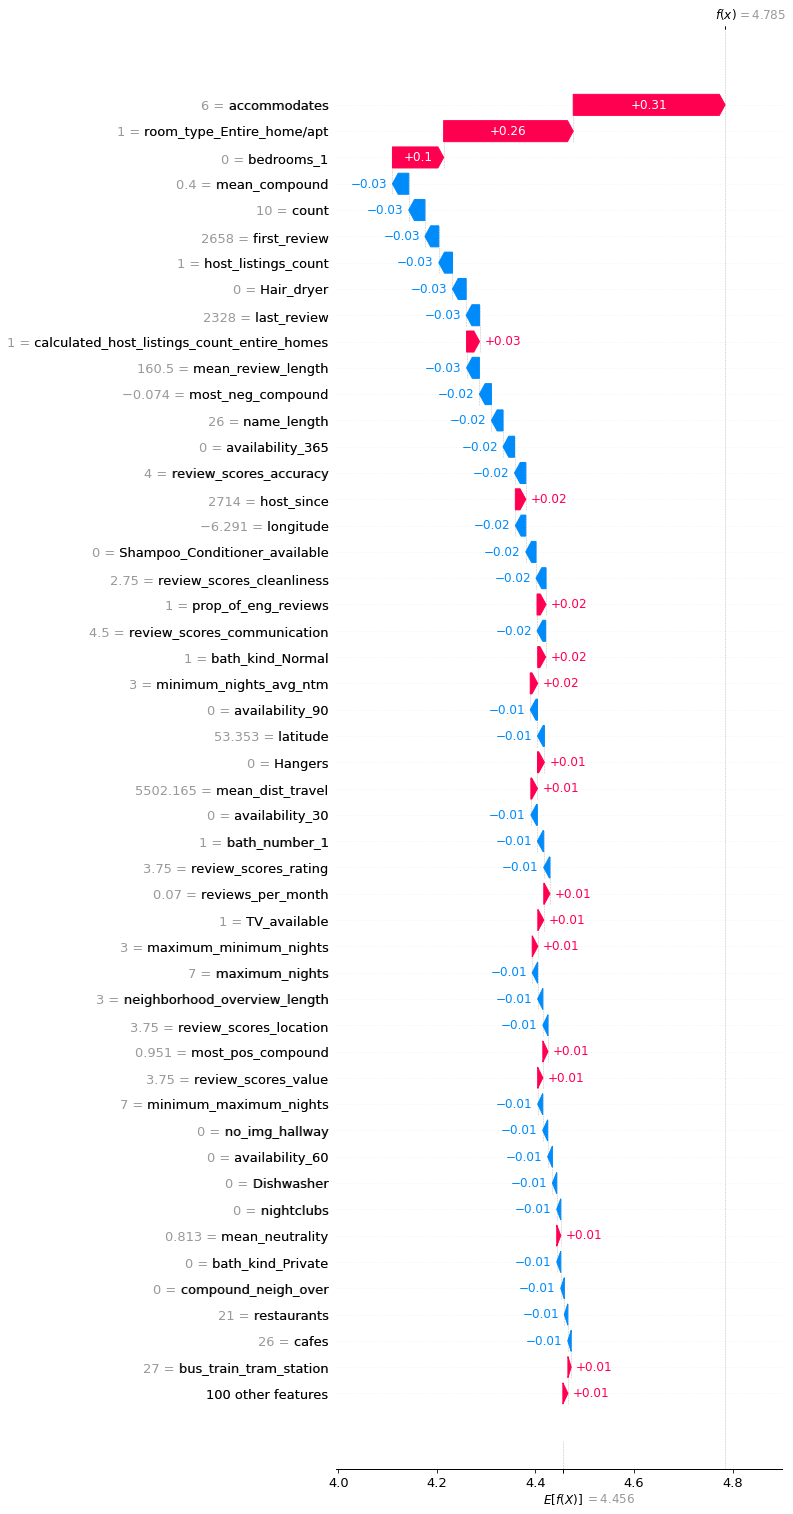

In [23]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[588], max_display = 50)

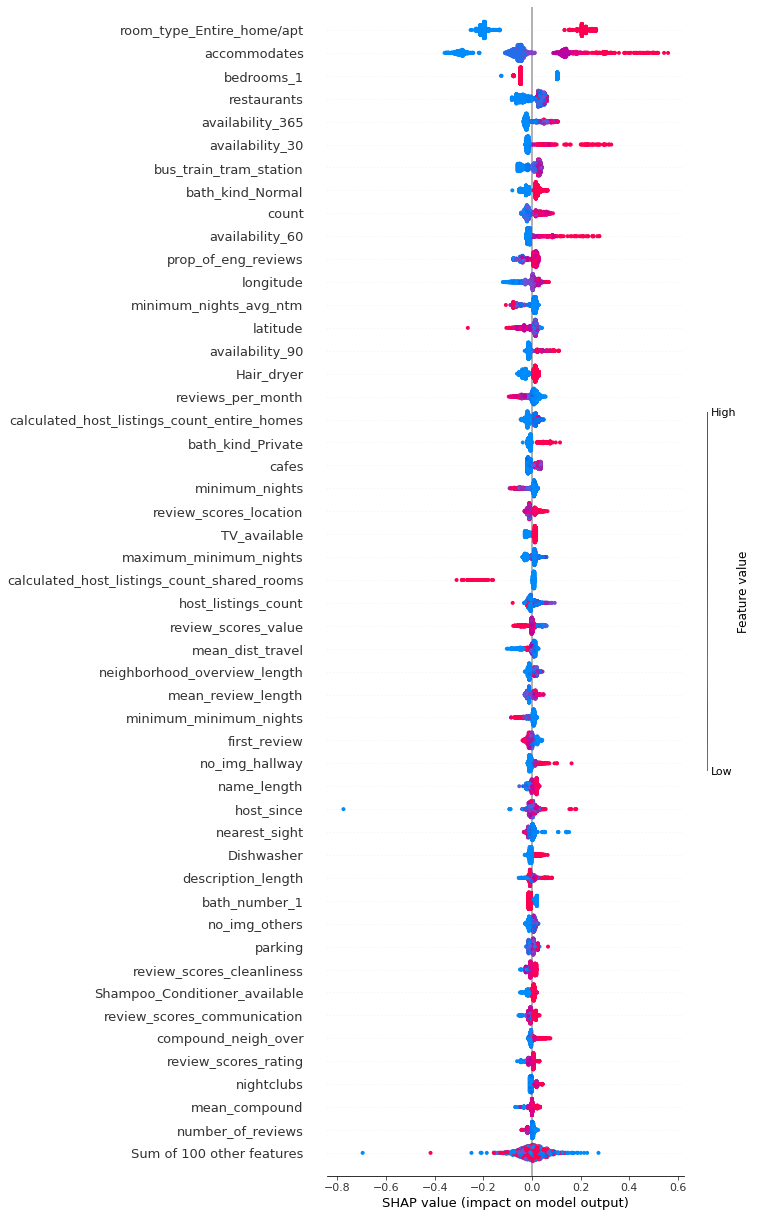

In [24]:
shap.plots.beeswarm(shap_values, max_display=50)


In [25]:
1 - (1-model_fold.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.6038239059197879

### Save best model

In [26]:
model_fold.save_model("xgBoost_models/model_nopca.json")

In [31]:
# load
opt_param = {
        'n_estimators': 100,
        'colsample_bytree': 0.5,
        'max_depth': 3,
        'gamma': 1,
        'reg_lambda': 10,
        'subsample': 0.9
        }

model_new = xgb.XGBRegressor(**opt_param)
model_new.load_model("xgBoost_models/model_nopca.json")

### Munich Data

In [29]:
X_munich, y_munich, X_munich_shap = load_data_munich_fold(fold = 1, for_dendro=True, verbose = 0)

In [32]:
model_new.score(X_munich, y_munich)

0.24361993890995604

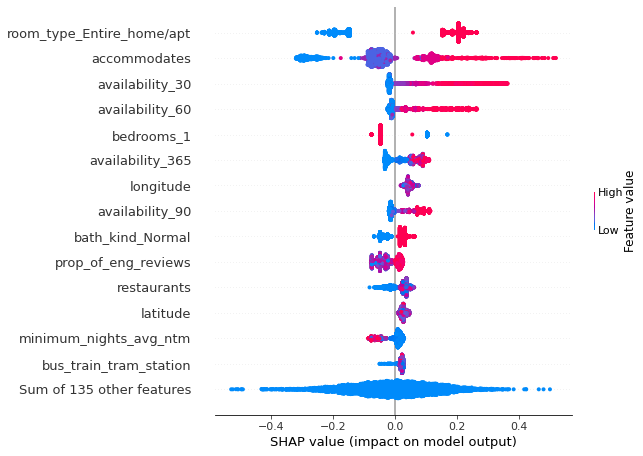

In [37]:
explainer = shap.Explainer(model_new)
shap_values = explainer(X_munich)
#shap_values = get_aggr_shap(shap_values)
shap_values.data = X_munich_shap
shap.plots.beeswarm(shap_values, max_display=15)
